<a href="https://colab.research.google.com/github/pavansai26/sentiment-analysis/blob/master/multiclass_sentiment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import pandas as pd
import numpy as np
import plotly.express as px
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow_hub as hub

In [2]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
data=pd.read_csv('/gdrive/My Drive/topical_chat.csv - Sheet1.csv')

In [5]:
data

conversation_id                                            message  \
0                     1              Are you a fan of Google or Microsoft?   
1                     1  Both are excellent technology they are helpful...   
2                     1   I'm not  a huge fan of Google, but I use it a...   
3                     1   Google provides online related services and p...   
4                     1   Yeah, their services are good. I'm just not a...   
...                 ...                                                ...   
188373             8628   Wow, it does not seem like that long. Since I...   
188374             8628   I havent seen that episode, I might google it...   
188375             8628  I don't think I have either. That's an insane ...   
188376             8628   I did, my little brother used to love Thomas ...   
188377             8628   It did. Ringo Starr, George Carlin, and Alec ...   

                     sentiment  
0       Curious to dive deeper  
1       Curious to dive deeper  
2       Curious to dive deeper  
3       Curious to dive deeper  
4       Curious to dive deeper  
...                        ...  
188373               Surprised  
188374  Curious to dive deeper  
188375  Curious to dive deeper  
188376                   Happy  
188377                 Neutral  

[188378 rows x 3 columns]

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [6]:
data.columns

Index(['conversation_id', 'message', 'sentiment'], dtype='object')

In [7]:
data.shape

(188378, 3)

In [8]:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188378 entries, 0 to 188377
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   conversation_id  188378 non-null  int64 
 1   message          188373 non-null  object
 2   sentiment        188378 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.3+ MB


In [9]:
data.isnull().sum()

conversation_id    0
message            5
sentiment          0
dtype: int64

# **Dropping unnecessary columns**

In [10]:
data.drop("conversation_id",axis=1,inplace=True)

In [11]:
data

message  \
0                   Are you a fan of Google or Microsoft?   
1       Both are excellent technology they are helpful...   
2        I'm not  a huge fan of Google, but I use it a...   
3        Google provides online related services and p...   
4        Yeah, their services are good. I'm just not a...   
...                                                   ...   
188373   Wow, it does not seem like that long. Since I...   
188374   I havent seen that episode, I might google it...   
188375  I don't think I have either. That's an insane ...   
188376   I did, my little brother used to love Thomas ...   
188377   It did. Ringo Starr, George Carlin, and Alec ...   

                     sentiment  
0       Curious to dive deeper  
1       Curious to dive deeper  
2       Curious to dive deeper  
3       Curious to dive deeper  
4       Curious to dive deeper  
...                        ...  
188373               Surprised  
188374  Curious to dive deeper  
188375  Curious to dive deeper  
188376                   Happy  
188377                 Neutral  

[188378 rows x 2 columns]

In [12]:
print("count of sentiment wise values : \n", data.sentiment.value_counts())

count of sentiment wise values : 
 Curious to dive deeper    80888
Neutral                   41367
Surprised                 30638
Happy                     29617
Sad                        2533
Disgusted                  1433
Fearful                    1026
Angry                       876
Name: sentiment, dtype: int64


In [13]:
fig = px.histogram(data, x='sentiment', title='Sentiment Count', color_discrete_sequence=['green'])
fig.update_layout(bargap=0.1)
fig.show()
fig = px.pie(data, names='sentiment',title="Sentiment Distribution")
fig.show()

# **inferences:**

# **Maximum tweets belong to Curious to dive deeper sentiment followed by neutral**

# **##Function to extract the message length**

In [14]:
def text_length(text):
    str_len=len(text.split(" "))
    return(str_len)
data['OriginalLength']= data['message'].astype(str).apply(lambda x:text_length(x))
data.head()

message               sentiment  \
0              Are you a fan of Google or Microsoft?  Curious to dive deeper   
1  Both are excellent technology they are helpful...  Curious to dive deeper   
2   I'm not  a huge fan of Google, but I use it a...  Curious to dive deeper   
3   Google provides online related services and p...  Curious to dive deeper   
4   Yeah, their services are good. I'm just not a...  Curious to dive deeper   

   OriginalLength  
0               8  
1              17  
2              29  
3              17  
4              21

In [15]:
data['message'].describe()

count                188373
unique               184112
top        Hi, how are you?
freq                    317
Name: message, dtype: object

In [16]:
fig = px.histogram(data, x="message", marginal='box', title="Length of messages")
#fig.update_layout(bargap=0.1)
fig.show()

In [25]:
import string

def data_cleaning(data):
    cleaned_data = []
    fillerWord = ("so","yeah","okay","um","uh","mmm","ahan","uh","huh","ahm","oh","sooo","uh","huh","yeh","yah","hmm","bye")
    fillerword_reg= "bye[.,]|so[.,]|yeah[.,]|okay[.,]|um[.,]|uh[.,]|mmm[.,]|ahan[.,]|uh[.,]|huh[.,]|ahm[.,]|oh[.,]|sooo[.,]|uh[.,]|huh[.,]|yeh[.,]|yah[.,]|hmm[.,]"
    STOPWORDS = set(stopwords.words('english'))
    remove=["doesn't","not","nor","neither","isn't","hadn't","mightn't","needn't","wasn't","don't","dont","havent"]
    for i in remove:
        STOPWORDS.discard(i)
    
    STOPWORDS.add(fillerWord)  
    for i in range(len(data)):
        tweet = re.sub("#", "", data[i])#extracting hashtags
        tweet = re.sub(r'^https?:\/\/.*[\r\n]*', '',tweet, flags=re.MULTILINE)#extracting links
        html=re.compile(r'<.*?>')#extracting html tags
        tweet =html.sub(r"", tweet)
        #extracting symbols and characters
        tweet=re.sub(r'@\w+',"",tweet)
        tweet=re.sub(r'#\w+',"",tweet) 
        tweet=re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', tweet) 
        punctuation = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""
        tweet.rstrip(string.punctuation)
        tweet=re.sub('[^A-Za-z\s]+',"", tweet)
        tweet = tweet.lower()
        tweet = tweet.split()
        #Lemmatization to normalise text
        tweet = [lemmatizer.lemmatize(word) for word in tweet if not word in STOPWORDS]
        tweet = ' '.join(tweet)
        filler=re.compile(fillerword_reg)
        tweet=filler.sub("",tweet)
        cleaned_data.append(tweet)
    return cleaned_data


In [26]:
####Preprocessing and cleaning train data
tex_to_data=data['message'].astype(str)
process_text=data_cleaning(tex_to_data)

cleaned_tweet =pd.DataFrame(process_text)
data['Cleaned_message']=cleaned_tweet
#cleaned_tweet.head()


data

message  \
0                   Are you a fan of Google or Microsoft?   
1       Both are excellent technology they are helpful...   
2        I'm not  a huge fan of Google, but I use it a...   
3        Google provides online related services and p...   
4        Yeah, their services are good. I'm just not a...   
...                                                   ...   
188373   Wow, it does not seem like that long. Since I...   
188374   I havent seen that episode, I might google it...   
188375  I don't think I have either. That's an insane ...   
188376   I did, my little brother used to love Thomas ...   
188377   It did. Ringo Starr, George Carlin, and Alec ...   

                     sentiment  OriginalLength  \
0       Curious to dive deeper               8   
1       Curious to dive deeper              17   
2       Curious to dive deeper              29   
3       Curious to dive deeper              17   
4       Curious to dive deeper              21   
...                        ...             ...   
188373               Surprised              41   
188374  Curious to dive deeper              19   
188375  Curious to dive deeper              20   
188376                   Happy              19   
188377                 Neutral              15   

                                          Cleaned_message  newlength  
0                                    fan google microsoft          3  
1       excellent technology helpful many way security...          8  
2       im not huge fan google use lot think monopoly ...         10  
3       google provides online related service product...         13  
4       yeah service good im not fan intrusive persona...          9  
...                                                   ...        ...  
188373  wow not seem like long since mentioned simpson...         19  
188374  havent seen episode might google later yeah si...          9  
188375  dont think either thats insane amount episode ...         12  
188376  little brother used love thomas tank engine re...         10  
188377    ringo starr george carlin alec baldwin narrated          7  

[188378 rows x 5 columns]

In [27]:
#Adding length of cleaned message to dataset
data['newlength']= data['Cleaned_message'].apply(lambda x:text_length(x))
data.head()

message               sentiment  \
0              Are you a fan of Google or Microsoft?  Curious to dive deeper   
1  Both are excellent technology they are helpful...  Curious to dive deeper   
2   I'm not  a huge fan of Google, but I use it a...  Curious to dive deeper   
3   Google provides online related services and p...  Curious to dive deeper   
4   Yeah, their services are good. I'm just not a...  Curious to dive deeper   

   OriginalLength                                    Cleaned_message  \
0               8                               fan google microsoft   
1              17  excellent technology helpful many way security...   
2              29  im not huge fan google use lot think monopoly ...   
3              17  google provides online related service product...   
4              21  yeah service good im not fan intrusive persona...   

   newlength  
0          3  
1          8  
2         10  
3         13  
4          9

In [28]:
print(data.newlength.describe())


count    188378.000000
mean         10.040344
std           5.511488
min           1.000000
25%           6.000000
50%           9.000000
75%          13.000000
max          69.000000
Name: newlength, dtype: float64


In [29]:
fig = px.histogram(data,
                  x='newlength',
                  marginal='box',
                  title="Length of cleaned messages",
                  color_discrete_sequence=['green'])
fig.update_layout(bargap=0.1)
fig.show()

# **Inferences:**
Range  0-30
outliers are there

# **Label Encoding of response i.e. Categorical Variables**

In [87]:
#target = encoder.fit_transform(data['sentiment'])
#target = pd.DataFrame(target,columns=['Sentiment'])
#target.shape
#target.head()

(188378, 1)

In [105]:
# Define the target variable and convert it to categorical
target = data['sentiment']
target = pd.get_dummies(target)
target

Angry  Curious to dive deeper  Disgusted  Fearful  Happy  Neutral  \
0           0                       1          0        0      0        0   
1           0                       1          0        0      0        0   
2           0                       1          0        0      0        0   
3           0                       1          0        0      0        0   
4           0                       1          0        0      0        0   
...       ...                     ...        ...      ...    ...      ...   
188373      0                       0          0        0      0        0   
188374      0                       1          0        0      0        0   
188375      0                       1          0        0      0        0   
188376      0                       0          0        0      1        0   
188377      0                       0          0        0      0        1   

        Sad  Surprised  
0         0          0  
1         0          0  
2         0          0  
3         0          0  
4         0          0  
...     ...        ...  
188373    0          1  
188374    0          0  
188375    0          0  
188376    0          0  
188377    0          0  

[188378 rows x 8 columns]

In [65]:
# Encode the text data using the Universal Sentence Encoder
x = embed(data['Cleaned_message'].values)
x

<tf.Tensor: shape=(188378, 512), dtype=float32, numpy=
array([[ 0.05883138,  0.00192946, -0.04197723, ...,  0.02176283,
        -0.01870417,  0.00734458],
       [-0.02771324, -0.04071624, -0.05632912, ..., -0.00646646,
        -0.02013201, -0.04543203],
       [ 0.03644262, -0.02983654, -0.00109376, ..., -0.03387139,
         0.02314877,  0.02628036],
       ...,
       [ 0.01027861, -0.01856943,  0.02666964, ...,  0.03942157,
         0.09295341, -0.01184051],
       [ 0.01940921,  0.04448948, -0.03222824, ..., -0.03946018,
         0.08133557,  0.01595825],
       [ 0.05657908,  0.05641292,  0.06749985, ...,  0.03389992,
         0.0599981 ,  0.06672171]], dtype=float32)>

In [103]:
#X_train, X_test, y_train, y_test = train_test_split(np.array(x).tolist(), np.array(target),test_size=0.2)


In [104]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(15000, 512)
(150702, 8)
(3878, 512)
(37676, 8)


In [63]:
#len(x)

188378

In [43]:
#x_train = x[:15000]

In [45]:
#x_test = x[:3878]

In [46]:
#len(target)

188378

In [47]:
#y_train = target[:15000]
#y_test = target [:3878]

In [44]:
#x_train

<tf.Tensor: shape=(15000, 512), dtype=float32, numpy=
array([[ 0.05883138,  0.00192946, -0.04197723, ...,  0.02176283,
        -0.01870417,  0.00734458],
       [-0.02771324, -0.04071624, -0.05632912, ..., -0.00646646,
        -0.02013201, -0.04543203],
       [ 0.03644262, -0.02983654, -0.00109376, ..., -0.03387139,
         0.02314877,  0.02628036],
       ...,
       [ 0.03753498,  0.03237302, -0.06150855, ..., -0.00817444,
        -0.0586635 , -0.01542833],
       [-0.03126906, -0.01841683,  0.04644109, ..., -0.04411995,
         0.02927632, -0.01411297],
       [ 0.0091258 , -0.07698577, -0.00039362, ..., -0.04593264,
        -0.06421425,  0.04901867]], dtype=float32)>

In [48]:
#y_train

Sentiment
0              1
1              1
2              1
3              1
4              1
...          ...
14995          1
14996          5
14997          4
14998          7
14999          1

[15000 rows x 1 columns]

In [111]:
# Define the model architecture
model = tf.keras.Sequential([
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(8, activation='softmax')
])

In [112]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [114]:
# Train the model
history = model.fit(x, target, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
4710/4710 [==============================] - 23s 5ms/step - loss: 1.3179 - accuracy: 0.4515 - val_loss: 1.3113 - val_accuracy: 0.4570
Epoch 2/20
4710/4710 [==============================] - 21s 4ms/step - loss: 1.2827 - accuracy: 0.4668 - val_loss: 1.3001 - val_accuracy: 0.4618
Epoch 3/20
4710/4710 [==============================] - 23s 5ms/step - loss: 1.2524 - accuracy: 0.4810 - val_loss: 1.3007 - val_accuracy: 0.4635
Epoch 4/20
4710/4710 [==============================] - 24s 5ms/step - loss: 1.2195 - accuracy: 0.4945 - val_loss: 1.3059 - val_accuracy: 0.4652
Epoch 5/20
4710/4710 [==============================] - 22s 5ms/step - loss: 1.1878 - accuracy: 0.5082 - val_loss: 1.3208 - val_accuracy: 0.4613
Epoch 6/20
4710/4710 [==============================] - 22s 5ms/step - loss: 1.1573 - accuracy: 0.5205 - val_loss: 1.3390 - val_accuracy: 0.4565
Epoch 7/20
4710/4710 [==============================] - 22s 5ms/step - loss: 1.1281 - accuracy: 0.5331 - val_loss: 1.3729 - val_ac

<ipython-input-117-1c8a7c84c3ba>:1: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



(0.0, 1.8416556060314178)

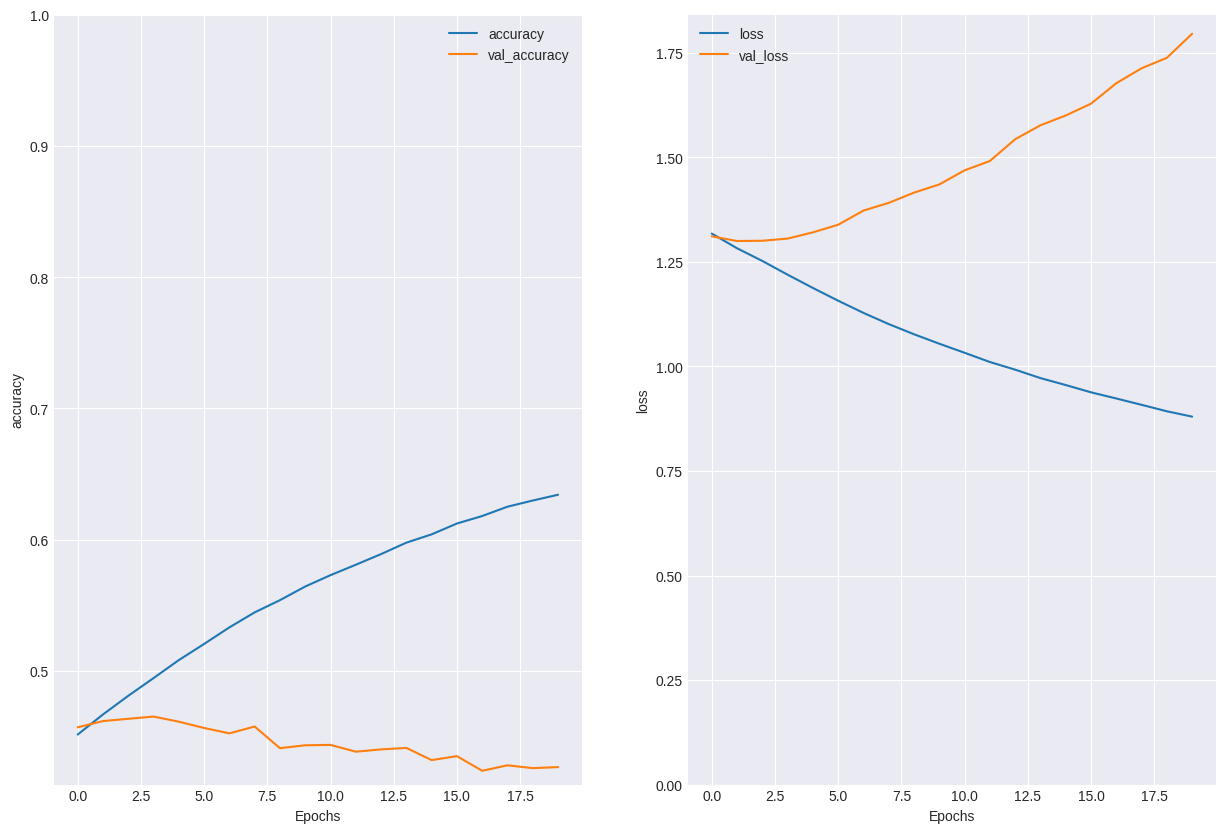

In [117]:
plt.style.use('seaborn-darkgrid')
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [119]:
y_pred = model.predict("I'm not a huge fan of Google, but I use it a lot because I have to.")


IndexError: ignored